In [50]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import keras.backend as K

# Experimentos com leilões usando modelo de redes neurais

### Caso 1
Temos dois jogadores (jogador "a" e jogador "b") usando a mesma estratégia (ou seja, usam o mesmo modelo de rede neural). Para cada jogador, atribuímos aleatoriamente valores de V (valor do leilão para o jogador) e B (lance dado - bid). O modelo recebe V e B e retorna U(V,B).
O leilão é realizado com o valores Va,Ba e Vb, Bb, e calculamos o valor real de Ua e Ub. Por fim, a rede é atualizada com com o valores das utilidade após o leilão.

In [51]:
# Modelo de igual para os dois jogadores, a entrada é o valor 
# percebido do leilão (Va ou Vb) e os lances (Ba ou Bb) e a saída é o Pay Off.

model2 = tf.keras.Sequential([
  tf.keras.layers.Dense(5, activation=tf.nn.relu, input_shape=(1,2)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(5, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.tanh)
])

model2.compile(loss='mean_squared_error', optimizer="Adam", metrics=["mse"])
model2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 1, 5)              15        
_________________________________________________________________
dense_45 (Dense)             (None, 1, 10)             60        
_________________________________________________________________
dense_46 (Dense)             (None, 1, 5)              55        
_________________________________________________________________
dense_47 (Dense)             (None, 1, 1)              6         
Total params: 136
Trainable params: 136
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Iterando sobre todas as simulações

for n in range(10000):
    
    # Valor e lance de Ana
    inp_a = np.random.uniform(0,1,(1, 2))
    Va = inp_a[0][0]
    Ba = inp_a[0][1]
    
    # Valor e lance de Bruno
    inp_b = np.random.uniform(0,1,(1, 2))
    Vb = inp_b[0][0]
    Bb = inp_b[0][1]
    
    
    # Pay Off esperado para Ana e Bruno segundo o modelo
    Pay_a = model2(inp_a)
    Pay_b = model2(inp_b)
    
    # Verificando quem vence o leilão e atualizando o modelo
    if Ba > Bb:
        Actual_pay_a = np.array([[Va - Ba]])
        model2.fit(inp_a, Actual_pay_a, verbose=0)
        
        Actual_pay_b = np.zeros(1)
        model2.fit(inp_b, Actual_pay_b, verbose=0)
    
    else:
        Actual_pay_a = np.zeros(1)
        model2.fit(inp_a, Actual_pay_a, verbose=0)
    
        Actual_pay_b = np.array([[Vb - Bb]])
        model2.fit(inp_b, Actual_pay_b, verbose=0)
    

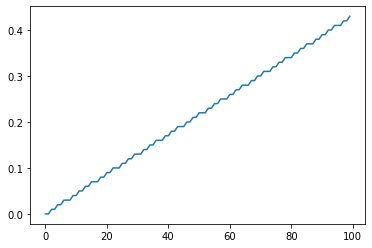

In [53]:
# Iterando sobre todos os valores de V e B para achar os maiores U(V,B).
max_pay_value = []
bid_max_value = []
for V in np.arange(0.0, 1.0, 1/100):
    max_pay = -1
    max_bid = 0
    for B in np.arange(0.0, 1.0, 1/100):
        inp = np.array([[V, B]])
        pay = model2(inp)
        if pay > max_pay:
            max_pay = pay
            max_bid = B
    max_pay_value.append(max_pay.numpy()[0][0])
    bid_max_value.append(max_bid)
#plt.plot(max_pay_value)
plt.plot(bid_max_value)

### Caso 2
No segundo caso, entramos com o valor V de cada jogador e a saída do modelo é a utilidade esperada. **(Mas acho que a modelagem não está correta)**

In [54]:
# Modelo de igual para os dois jogadores, a entrada é o valor 
# percebido do leilão (Va e Vb) e a saída são os pay off (pay_a e pay_b).

model = tf.keras.Sequential([
  tf.keras.layers.Dense(5, activation=tf.nn.relu, input_shape=(1,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(5, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.tanh)
])

model.compile(loss='mean_squared_error', optimizer="Adam", metrics=["mse"])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_49 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_50 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 6         
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Iterando sobre todas as simulações

for n in range(10000):
    
    # Valor de Ana e Bruno
    Va = np.random.uniform(0,1,1)
    Vb = np.random.uniform(0,1,1)
    
    #Ba = model(Va)
    #Bb = model(Vb)
    
    # Pay Off esperado para Ana e Bruno segundo o modelo
    Pay_a = model(Va)
    Pay_b = model(Vb)
    
    # Se pay off de Ana for menor do que zero, o lance da ana será zero. Senão será o valor menos o pay off.
    if Pay_a < 0:
        Ba = np.zeros(1)
    else:
        Ba = Va - Pay_a
    # Se o valor menos o pay off for menor do que zero, seu lance será zero.
    if Ba < 0:
        Ba = 0
    
    # Se pay off de Bruno for menor do que zero, o lance da ana será zero. Senão será o valor menos o pay off.
    if Pay_b < 0:
        Bb = np.zeros(1)
    else:
        Bb = Vb - Pay_b
    # Se o valor menos o pay off for menor do que zero, seu lance será zero
    if Bb < 0:
        Bb = 0
    
    # Leilão
    if Ba == Bb:
        pass
    else:
        if Ba > Bb:
            # Atualizando o modelo com os dados de Ana
            model.fit(Va, Va - Bb, verbose=0)
            # Atualizando o modelo com os dados de Bruno
            model.fit(Vb, np.zeros(1), verbose =0)
        else:
            # Atualizando o modelo com os dados de Ana
            model.fit(Va, np.zeros(1), verbose=0)
            # Atualizando o modelo com os dados de Bruno
            model.fit(Vb, Vb - Ba, verbose =0)

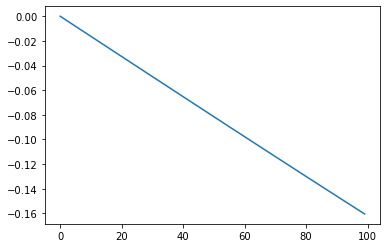

In [56]:
#Valores = np.arange(0.0, 1.0, 1/100) - model(np.arange(0.0, 1.0, 1/100)).numpy().reshape(-1)
#plt.plot(Valores)
plt.plot(model(np.arange(0.0, 1.0, 1/100)))

### Caso 3
No terceiro caso, a entrada do modelo é o Valor do leilão e a saída é o Lance(bid). **(Neste caso a atulização do bid não está boa, provavelmente temos que usar a equação de Bellman para reinforcement learning)**

Modelo 3 

In [57]:
# Modelo de igual para os dois jogadores, a entrada é o valor 
# percebido do leilão (Va e Vb) e a saída são os lances (ba e bb).

model3 = tf.keras.Sequential([
  tf.keras.layers.Dense(5, activation=tf.nn.relu, input_shape=(1,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(5, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model3.compile(loss='mean_squared_error', optimizer="Adam", metrics=["mse"])
model3.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_53 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_54 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 6         
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [58]:
for n in range(10000):

    # Valor de Ana e Bruno
    Va = np.random.uniform(0,1,1)
    Vb = np.random.uniform(0,1,1)

    Ba = model3(Va)
    Bb = model3(Vb)
    #Bmedio = (Ba + Bb)/2

    if Ba > Bb:
        Pay_a = Va - Ba
        Pay_b = np.zeros(1)
        actual_Ba = Ba*(1 - (Ba - Bb)/10)
        actual_Bb = Bb*(1 + (Vb - Bb)/10)
        
    else:
        Pay_a = np.zeros(1)
        Pay_b = Vb - Bb
        actual_Bb = Bb*(1 - (Bb - Ba)/10)
        actual_Ba = Ba*(1 + (Va - Ba)/10)

    #actual_Ba = Bmedio
    #actual_Bb = Bmedio.

    if Pay_a < 0:
        actual_Ba = Va
    if Pay_b < 0:
        actual_Bb = Vb

    model3.fit(Va, actual_Ba, verbose=0)

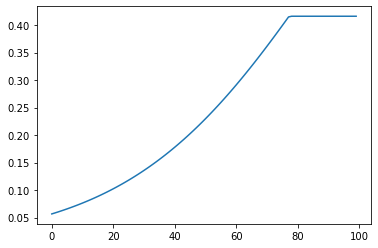

In [59]:
plt.plot(model3(np.arange(0.0, 1.0, 1/100)))